In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
#from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

2024-02-09 22:29:15.626009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 22:29:15.626113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 22:29:15.791983: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_data='/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training'

In [3]:
test_data='/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test'

In [4]:
def get_data(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

X_train, Y_train, labels = get_data(train_data)
X_test, Y_test,_ = get_data(test_data)

In [5]:
from keras.utils import to_categorical

In [6]:
Y_train = to_categorical(Y_train, 131)
Y_test = to_categorical(Y_test, 131)

In [7]:
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=33)
Y_train, Y_val = train_test_split(Y_train, test_size=0.2, random_state=33)

In [8]:
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

In [9]:
X_train = np.array(convert_image_to_array(X_train))
X_val = np.array(convert_image_to_array(X_val))
X_test = np.array(convert_image_to_array(X_test))

In [10]:
X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
X_test = X_test.astype('float32')/255

In [11]:
# Mobilenet Backbone
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

IMAGE_SIZE = 100
print("Loading MobileNet Backbone: ")#APPLYING MOBILENETV2 MODEL 
mobilenet = MobileNetV2(input_shape=(100,100, 3), weights='imagenet', include_top=False)

# Freeze the model weights
mobilenet.trainable = False

# The Mobilenet Model baseline
#current model contains moile
mobilenet = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(131, activation='softmax')
])

# Compile the Baseline
mobilenet.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# Train the Xception Baseline Model
print("\nTraining Baseline Model: ")
history = mobilenet.fit(
    X_train, Y_train, 
    validation_data=(X_val, Y_val), 
    epochs=20, 
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint("MobileNetV2Baseline.h5", save_best_only=True)
    ],
    batch_size=128
)

# Testing Evaluation
mobilenet_test_loss, mobilenet_test_acc = mobilenet.evaluate(X_test, Y_test)
print(f"\nMobileNet Baseline Testing Loss     : {mobilenet_test_loss}.")
print(f"MobileNet Baseline Testing Accuracy : {mobilenet_test_acc}.")

Loading MobileNet Backbone: 

Training Baseline Model: 
Epoch 1/20
  1/424 [..............................] - ETA: 51:36 - loss: 6.6764 - accuracy: 0.0000e+00

I0000 00:00:1707518540.686266     711 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


424/424 [==============================] - ETA: 0s - loss: 0.5688 - accuracy: 0.8661

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


424/424 [==============================] - 34s 64ms/step - loss: 0.5688 - accuracy: 0.8661 - val_loss: 0.0322 - val_accuracy: 0.9967
Epoch 2/20
424/424 [==============================] - 21s 48ms/step - loss: 0.0533 - accuracy: 0.9884 - val_loss: 0.0101 - val_accuracy: 0.9994
Epoch 3/20
424/424 [==============================] - 21s 49ms/step - loss: 0.0267 - accuracy: 0.9947 - val_loss: 0.0063 - val_accuracy: 0.9997
Epoch 4/20
424/424 [==============================] - 21s 49ms/step - loss: 0.0173 - accuracy: 0.9969 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 5/20
424/424 [==============================] - 21s 49ms/step - loss: 0.0116 - accuracy: 0.9981 - val_loss: 0.0023 - val_accuracy: 0.9999
Epoch 6/20
424/424 [==============================] - 21s 49ms/step - loss: 0.0093 - accuracy: 0.9984 - val_loss: 0.0020 - val_accuracy: 0.9999
Epoch 7/20
424/424 [==============================] - 21s 49ms/step - loss: 0.0076 - accuracy: 0.9987 - val_loss: 0.0016 - val_accuracy: 0.9998
Epo

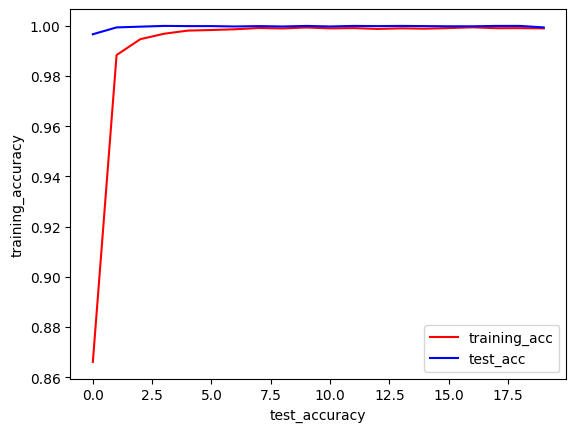

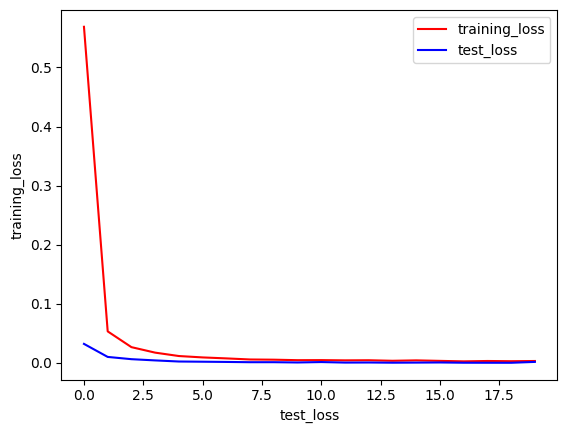

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color = 'red',label = 'training_acc')
plt.plot(history.history['val_accuracy'],color = 'blue',label = 'test_acc')
plt.ylabel('training_accuracy')
plt.xlabel('test_accuracy')
plt.legend()
plt.show()




plt.plot(history.history['loss'],color = 'red',label = 'training_loss')
plt.plot(history.history['val_loss'],color = 'blue',label = 'test_loss')
plt.ylabel('training_loss')
plt.xlabel('test_loss')
plt.legend()
plt.show()


709/709 [==============================] - 8s 10ms/step


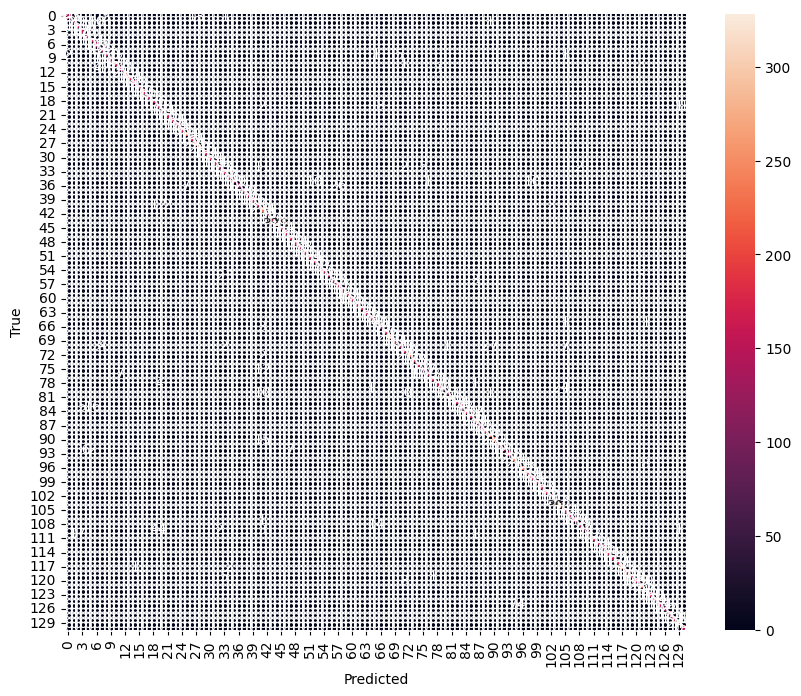

709/709 [==============================] - 9s 12ms/step - loss: 0.1707 - accuracy: 0.9607
Test accuracy is 0.960684061050415 and test loss is 0.1707117110490799


In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


y_pred = mobilenet.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_mtx = confusion_matrix(np.argmax(Y_test, axis=1), y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

test_loss, test_acc = mobilenet.evaluate(X_test, Y_test)
print(f"Test accuracy is {test_acc} and test loss is {test_loss}")


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on test set
Y_pred = mobilenet.predict(X_test)
# Convert predictions to one-hot encoded labels
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true_labels, Y_pred_labels)

# Classification Report
class_report = classification_report(Y_true_labels, Y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


709/709 [==============================] - 7s 10ms/step
Confusion Matrix:
[[145   0   0 ...   0   0   0]
 [  0 129   0 ...   0   0   0]
 [  0   0 160 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       164
           1       1.00      0.87      0.93       148
           2       0.90      1.00      0.95       160
           3       0.64      0.99      0.78       164
           4       0.99      0.63      0.77       161
           5       0.90      1.00      0.95       164
           6       0.75      0.97      0.84       152
           7       0.85      0.79      0.82       164
           8       0.84      0.91      0.87       164
           9       0.98      0.92      0.95       144
          10       1.00      0.98      0.99       166
          11       0.95      0.87      0.91       164
       